# Stereo to Depth Maps

Converting two images that are already stereo rectified to depth maps (colored point clouds).

In [1]:
# Import everything
import numpy as np
import cv2 as cv
from PIL import Image
import open3d as o3d
from matplotlib import pyplot as plt
import os

A good source for stereo data is [Middlebury Stereo Vision](https://vision.middlebury.edu/stereo/data/) dataset

Load images

In [2]:
# Left image
left_img_path = "./../images/stereo/middlebury/cones/im2.ppm"
# Right image
right_img_path = "./../images/stereo/middlebury/cones/im6.ppm"
# Ground truth
disp_gt_path = "./../images/stereo/middlebury/cones/disp2.pgm"

# Assert files exist
assert os.path.isfile(left_img_path)
assert os.path.isfile(right_img_path)
assert os.path.isfile(disp_gt_path)

Visualize images

In [3]:
# View the data
left_img_pil = Image.open(left_img_path)
right_img_pil = Image.open(right_img_path)

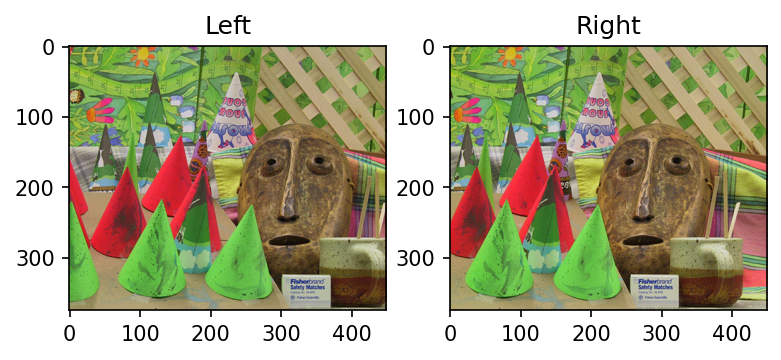

In [4]:
# Show images
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.title("Left")
plt.imshow(left_img_pil)
plt.subplot(1,2,2)
plt.title("Right")
plt.imshow(right_img_pil)
plt.show()

## Disparity Map



### Ground truth

From the dataset

In [5]:
# View data
disp_gt_pil = Image.open(disp_gt_path)

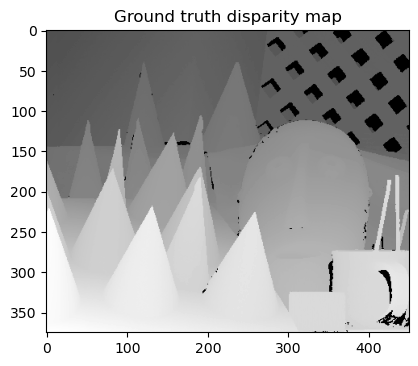

In [6]:
# View images
plt.figure(dpi=100)
plt.title("Ground truth disparity map")
plt.imshow(disp_gt_pil, cmap='gray')
plt.show()

In [7]:
gt_disp_map = np.array(disp_gt_pil)/4.0

### OpenCV Functions

See
- [cv.StereoMatcher](https://docs.opencv.org/4.x/d2/d6e/classcv_1_1StereoMatcher.html) class
- [H Hirschmuller (2008) - Stereo processing by semiglobal matching and mutual information](https://doi.org/10.1109/TPAMI.2007.1166): SGBM paper

The inbuilt functions work only on grayscale images


In [23]:
stereo = cv.StereoSGBM_create(numDisparities=64, blockSize=15)
left_img = np.array(left_img_pil)
right_img = np.array(right_img_pil)
disp_cv_unscaled = stereo.compute(
    cv.cvtColor(left_img, cv.COLOR_BGR2GRAY),
    cv.cvtColor(right_img, cv.COLOR_BGR2GRAY))

In [28]:
# Scale the disparity map
dmin, dmax = np.min(disp_cv_unscaled), np.max(disp_cv_unscaled)
disp_cv_map = ((disp_cv_unscaled - dmin)/(dmax - dmin)) * 255
disp_cv_map /= 4.0

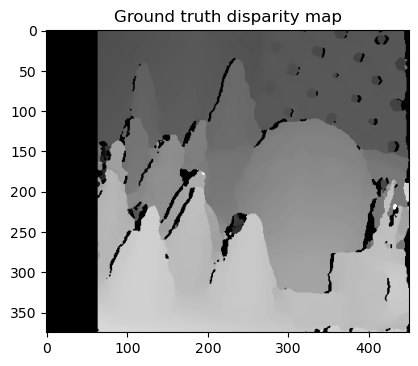

In [29]:
# View images
plt.figure(dpi=100)
plt.title("Disparity map using OpenCV")
plt.imshow(disp_cv_map, cmap='gray')
plt.show()

## Point Cloud

Constructing point clouds from the disparity maps


In [40]:
# Properties of the cameras
B = 0.40    # Baseline (in m)
f = 3.5e2    # Focal length (in m)
disp_map = gt_disp_map  # Choose disparity map
col_img = np.array(left_img_pil)    # Grab color from this image

Offset the pixels so that the origin is at the center of image.

In [41]:
py, px = np.where(disp_map > 0.0)
disp_vals = disp_map[py, px]
rpx, rpy = px.copy(), py.copy()
py = py - disp_map.shape[0]/2
px = px - disp_map.shape[1]/2

Convert the points to disparity using the following equation

$$
X = \frac{(x' - w_c)B}{d_{x'-x''}} \qquad
Y = \frac{(y' - h_c)B}{d_{x'-x''}} \qquad
Z = \frac{fB}{d_{x'-x''}}
$$

In [42]:
pts_Z = (B*f)/disp_vals
pts_X = px * B/disp_vals
pts_Y = py * B/disp_vals

### Visualization

First, let's create a view helper function

In [43]:
def custom_draw_geometry(pcds, look_at=[0, 0.1, 0], 
        cam_front=[-1, 0, 0.2], cam_up=[0, 1, 0], cam_zoom=1.0,
        title="Custom View", width=1080, height=720):
    """
    Draws geometry with the specified camera parameters
    
    Parameters:
    - pcds: [geometry]
        A list of geometry objects
    - look_at: (3,1)
        A vector that will be at center of window
    - cam_front: (3,1)
        A vector where the camera front is located
    - cam_up: (3, 1)
        A vector that points upwards to the camera
        for orientation information
    - cam_zoom: float
        The zoom for camera
    - title: str    default: "Custom View"
        The title of window
    - width: int    default: 1080
        Width of display window
    - height: int    default: 720
        Height of the display window
    """
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=title, width=width, height=height)
    for pcd in pcds:
        vis.add_geometry(pcd)
    ctr = vis.get_view_control()
    ctr.set_lookat(look_at)
    ctr.set_front(cam_front)
    ctr.set_zoom(cam_zoom)
    ctr.set_up(cam_up)
    vis.run()
    vis.destroy_window()

In [44]:
# Create a point cloud
pc = o3d.geometry.PointCloud()
# Assign points
pc.points = o3d.utility.Vector3dVector(np.stack(
    (pts_X, pts_Y, pts_Z)).T)
# Colors from image
pc.colors = o3d.utility.Vector3dVector(col_img[rpy, rpx]/255.0)
# Axis frame (for visualizing)
ax = o3d.geometry.TriangleMesh.create_coordinate_frame()

In [45]:
rot_m = np.array([
    [0, 0, 1],
    [-1, 0, 0],
    [0, -1, 0]
])
pc.rotate(rot_m, [0, 0, 0])

PointCloud with 163321 points.

In [46]:
custom_draw_geometry([pc, ax], look_at=[2., 1., 1.], 
    cam_front=[-1., 0.2, 0.2], cam_up=[0., 0., 1.], cam_zoom=0.1)